In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt # for visualizations
import seaborn as sns # for visualizations
import numpy as np

#model packages
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import statsmodels.api as sm #linear regression tool
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#Pre-processing and metrics
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing #for normalizing values
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
#read the csv to a dataframe
df = pd.read_csv("../data/salary-cap-data.csv", encoding= 'utf-8')
df.info() #check to ensure it worked
df.head(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Team            192 non-null    object 
 1   Year            192 non-null    int64  
 2   Wins            192 non-null    int64  
 3   Losses          192 non-null    int64  
 4   Ties            192 non-null    int64  
 5   Classification  192 non-null    object 
 6   QB              192 non-null    int64  
 7   RB              192 non-null    int64  
 8   WR              192 non-null    int64  
 9   TE              192 non-null    int64  
 10  OL              192 non-null    int64  
 11  Offense         192 non-null    int64  
 12  DL              192 non-null    int64  
 13  LB              192 non-null    int64  
 14  S               192 non-null    int64  
 15  CB              192 non-null    int64  
 16  Defense         192 non-null    int64  
 17  SpecialTeams    192 non-null    int

,Team,Year,Wins,Losses,Ties,Classification,QB,RB,WR,TE,...,DL,LB,S,CB,Defense,SpecialTeams,DeadMoney,Total,CapMax,PercentUsed
0,49ers,2013,12,4,0,Good,2843160,9257768,16945177,10569598,...,11028483,17860800,10696955,12885741,52471979,6831666,6601496,116398504,123000000,0.946329
1,Bears,2013,8,8,0,Mediocre,11276471,12036166,16580067,2495000,...,29744128,12474915,3802254,15375000,61396297,6290000,2854947,120145053,123000000,0.976789


In [20]:
X_train, X_test = train_test_split(df, test_size = 0.2, random_state = 2, stratify = df['Classification']) # splits the data into two parts with 1:4 ratio
print(X_train.shape)
print(X_test.shape)

(153, 32)
(39, 32)


In [21]:
#set the training and testing data
X = X_train[['QB','RB', 'WR', 'TE', 'OL', 'DL', 'LB', 'S', 'CB', 'SpecialTeams', 'PercentUsed']]
y = X_train.Wins
X = sm.add_constant(X) #add the constant to the model
mod = sm.OLS(y, X, hasconst= True) #create the ordinary least squares model
res = mod.fit() #fit the model
print(res.summary()) #summarize the model

                            OLS Regression Results                            
Dep. Variable:                   Wins   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     3.529
Date:                Mon, 19 Oct 2020   Prob (F-statistic):           0.000217
Time:                        15:21:02   Log-Likelihood:                -366.56
No. Observations:                 153   AIC:                             757.1
Df Residuals:                     141   BIC:                             793.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.8795      2.474     -2.376   

In [5]:
#create the tests sets
Xtest = X_test[['QB','RB', 'WR', 'TE', 'OL', 'DL', 'LB', 'S', 'CB', 'SpecialTeams', 'PercentUsed']]
ytest = X_test.Wins #wins is the predicted dependent variable
Xtest = sm.add_constant(Xtest)

res.predict(Xtest);  #predict based off the test input

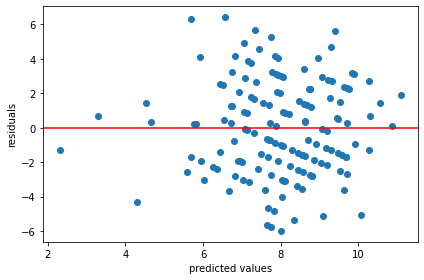

In [6]:
#plot the residuals
residuals = res.resid

y_pred = res.predict(X)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color = 'red', label = '0')

plt.xlabel('predicted values')
plt.ylabel('residuals')
plt.tight_layout()

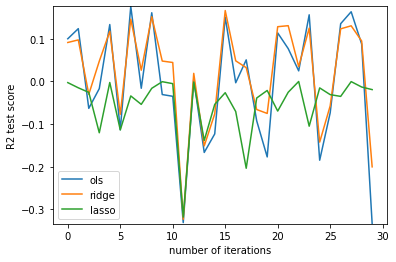

In [7]:
#in this model, there is collinearity between the different features - they are not entirely independent
#for example, if a team spends more on a quarterback, they will have to spend less elsewhere.. what they spend
#on a certain position depends on what they spent on the rest.
#for that reason, ridge or lasso regression may give better results than the standard linear regression
#lets try it out below...

#this from the lecture notes...
def model_experiment(num_iter = 5, 
                     models = ['ols', 'ridge', 'lasso'], alpha= 10, 
                     complexity = 'simple', degree = 3):
    
    X_train, X_test = train_test_split(df, test_size = 0.2) # splits the data into two parts with 1:4 ratio
    X = X_train[['QB','RB', 'WR', 'TE', 'OL', 'DL', 'LB', 'S', 'CB', 'SpecialTeams', 'PercentUsed']]
    y = X_train.Wins
    
    x_axis = np.arange(num_iter)
    y_ols_test = []
    y_lasso_test = []
    y_ridge_test = []
    sample_models = {}
    for i in range(num_iter):
        
        if complexity == 'simple':
            ## split train_test 
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
        elif complexity == 'polynomial':
            ## Create higher order terms
            poly = PolynomialFeatures(degree=degree)
            Xp = poly.fit_transform(X)
            ## test-train split
            X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size = 0.2)


        ## Standard scale mean = 0, variance = 1
        sd = StandardScaler()

        sd.fit(X_train)

        X_train = sd.transform(X_train)

        X_test = sd.transform(X_test)

        ## Be careful about the leakage

        ## Vanilla model
        if 'ols' in models:
            lr = LinearRegression()

            lr.fit(X_train, y_train)
            
            sample_models['ols'] = lr

            test_score = lr.score(X_test, y_test)
            train_score = lr.score(X_train, y_train)

            y_ols_test.append(test_score)

    #       print('test score OLS is %.2f and train score is %.2f'%(test_score, train_score))

        if 'ridge' in models:
            ## Ridge in the simple setting
            ridge = Ridge(alpha = alpha, max_iter= 10000)
            ridge.fit(X_train, y_train)
            sample_models['ridge'] = ridge
            y_ridge_test.append(ridge.score(X_test, y_test))
    #         print('test score Ridge is %.2f and train score is %.2f'%(ridge.score(X_test, y_test),
    #                                                             ridge.score(X_train, y_train)))

        if 'lasso' in models:
            ## Lasso in the simple setting
            lasso = Lasso(alpha = alpha, max_iter= 10000)

            lasso.fit(X_train, y_train)
            
            sample_models['lasso'] = lasso
            
            y_lasso_test.append(lasso.score(X_test, y_test))
    #       print('test score Lasso is %.2f and train score is %.2f'%(lasso.score(X_test, y_test),
    #                                                             lasso.score(X_train, y_train)))

        i+=1
    if 'ols' in models:
        plt.plot(y_ols_test, label = 'ols')
    if 'ridge' in models:
        plt.plot(y_ridge_test, label = 'ridge')
    if 'lasso' in models:
        plt.plot(y_lasso_test, label = 'lasso')
    plt.ylabel('R2 test score')
    plt.xlabel('number of iterations')
    all_results = y_ols_test + y_lasso_test + y_ridge_test
    plt.ylim((np.min(all_results), np.max(all_results)))
    
    plt.legend()
    return sample_models

trained_models = model_experiment(num_iter=30, alpha = 30,
                                   models = ['ols', 'ridge', 'lasso'], 
                                   complexity= 'simple', degree = 3)


In [22]:
# After run model_experiment with complexity == 'polynomial'

lr_ols = trained_models['ols']
lr_lasso = trained_models['lasso']
lr_ridge =trained_models['ridge']

# check the coefficients from Lasso

print(lr_ridge.coef_)
print(lr_lasso.coef_)

# compare them with OLS/Ridge models.

[-0.01443474  0.13745283  0.02812394  0.32744167 -0.14978373 -0.36728256
  0.16512962  0.17396071 -0.37141031  0.33308903  1.07769935]
[ 0.  0.  0.  0. -0. -0.  0.  0. -0.  0.  0.]


In [23]:
def normalize(x, col_max, col_min):
    return ((x - col_min) / (col_max - col_min))

#normalize the values for each position
for position in ['QB','RB', 'WR', 'TE', 'OL', 'DL', 'LB', 'S', 'CB', 'SpecialTeams']:
    df['norm' + position] = df[position].apply(lambda x: normalize(x, df[position].max(), df[position].min()))
df.head(2)

,Team,Year,Wins,Losses,Ties,Classification,QB,RB,WR,TE,...,normQB,normRB,normWR,normTE,normOL,normDL,normLB,normS,normCB,normSpecialTeams
0,49ers,2013,12,4,0,Good,2843160,9257768,16945177,10569598,...,0.045792,0.496506,0.445637,0.601705,0.303146,0.124968,0.362279,0.347406,0.365889,0.631449
1,Bears,2013,8,8,0,Mediocre,11276471,12036166,16580067,2495000,...,0.273408,0.672399,0.433855,0.080535,0.102124,0.519290,0.223023,0.058773,0.448341,0.571961


In [24]:
#lets try linear regression again
X_train, X_test = train_test_split(df, test_size = 0.2, random_state = 2, stratify = df['Classification']) # splits the data into two parts with 1:4 ratio
print(X_train.shape)
print(X_test.shape)

(153, 32)
(39, 32)


In [25]:
#set the training and testing data
X = X_train[['normQB','normRB', 'normWR', 'normTE', 'normOL', 'normDL', 'normLB', 'normS', 'normCB', 'normSpecialTeams', 'PercentUsed']]
y = X_train.Wins
X = sm.add_constant(X) #add the constant to the model
mod = sm.OLS(y, X, hasconst= True) #create the ordinary least squares model
res = mod.fit() #fit the model
print(res.summary()) #summarize the model


#####
#NOTE:
#it turns out this is no better than the original model - normalizing in this way doesn't do anything just makes
#the coeficients larger as the feature values are smaller which does nothing for the accuracy
#Probably an experiment that did not need to be done...
#####

                            OLS Regression Results                            
Dep. Variable:                   Wins   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     3.529
Date:                Mon, 19 Oct 2020   Prob (F-statistic):           0.000217
Time:                        16:12:14   Log-Likelihood:                -366.56
No. Observations:                 153   AIC:                             757.1
Df Residuals:                     141   BIC:                             793.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.8549      2.515  

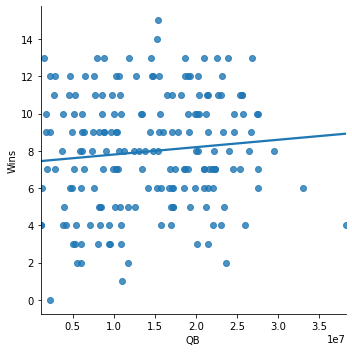

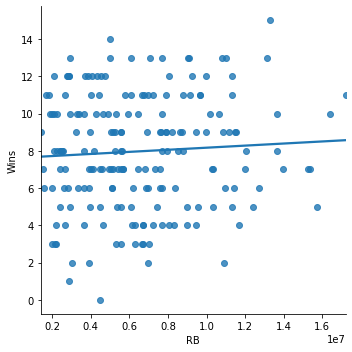

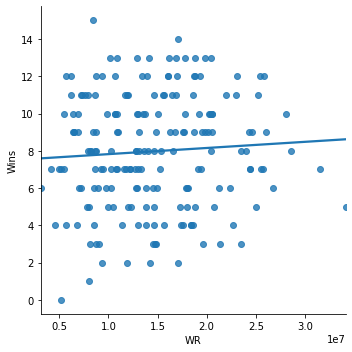

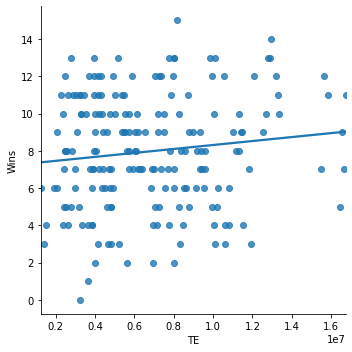

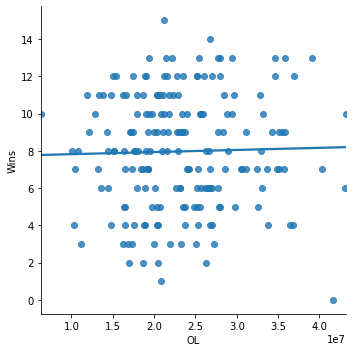

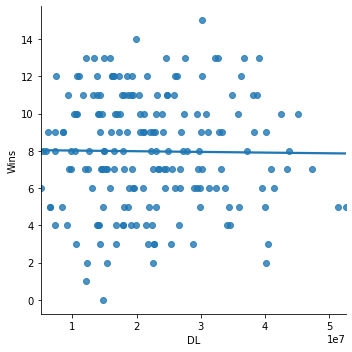

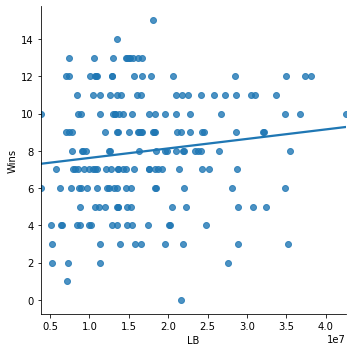

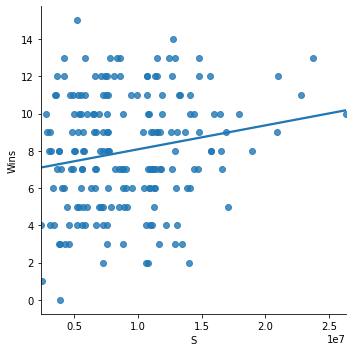

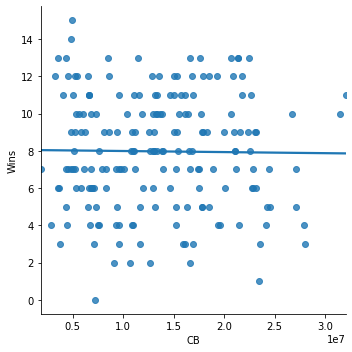

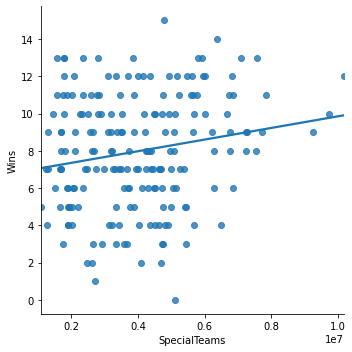

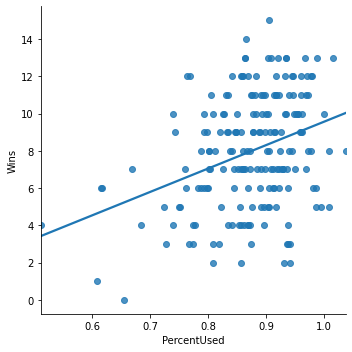

In [26]:
## let's use seaborn to plot a regression line
for position in ['QB','RB', 'WR', 'TE', 'OL', 'DL', 'LB', 'S', 'CB', 'SpecialTeams', 'PercentUsed']:
    sns.lmplot(x = position, y = 'Wins', data = df, ci = 0)
    plt.draw()

In [27]:
#from the lecture notes...
def draw_tree(estimator, figsize =(15, 5), feature_names = ["Hits", "Years"]):
    """
    Takes a decision  tree estimator and plots it's tree structure
    :param estimator: A sklearn decision tree estimator. Should be fitted.
    :param figsize: tuple. (int, int).
    :param feature_names:
    :return: It returns a plot. The image is not saved.
    """
    fig = plt.figure(figsize= figsize)
    _ = tree.plot_tree(estimator,
                       feature_names= feature_names,
                       filled=True)

In [28]:
#what is the dummy accuracy if we always just predict the dominant category?
df["Classification"].value_counts()

Mediocre    65
Good        65
Bad         62
Name: Classification, dtype: int64

In [29]:
#dummy accuracy predicting the dominant classification
65 / (65 + 65 + 62)

0.3385416666666667

In [30]:
# Goal - classify the correct category better than 33.85%

         QB        RB        WR        TE        OL        DL        LB  \
0   2843160   9257768  16945177  10569598  17479156  11028483  17860800   
1  11276471  12036166  16580067   2495000  10071052  29744128  12474915   

          S        CB  SpecialTeams  PercentUsed  
0  10696955  12885741       6831666     0.946329  
1   3802254  15375000       6290000     0.976789  
[[ 1  2 10]
 [ 2  2  9]
 [ 2  4  7]]
              precision    recall  f1-score   support

         Bad       0.20      0.08      0.11        13
        Good       0.25      0.15      0.19        13
    Mediocre       0.27      0.54      0.36        13

    accuracy                           0.26        39
   macro avg       0.24      0.26      0.22        39
weighted avg       0.24      0.26      0.22        39



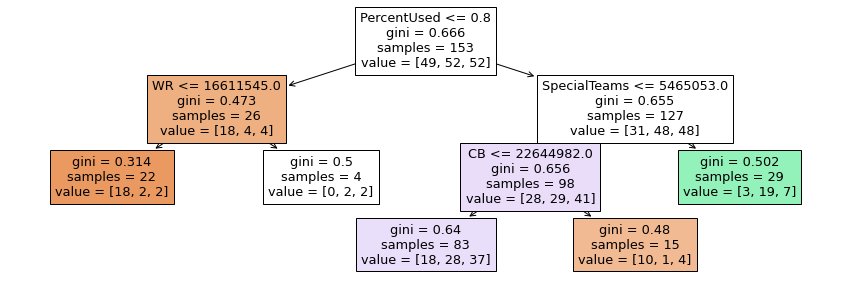

In [197]:
## here let's apply sklearn DecisionTreeClassifier
X = df.drop(['Team', 'Year', 'Wins', 'Losses', 'Ties', 'Classification', 'Offense', 'Defense', 'Total', 'DeadMoney', 'CapMax', 'normQB','normRB', 'normWR', 'normTE', 'normOL', 'normDL', 'normLB', 'normS', 'normCB', 'normSpecialTeams'], axis=1)
y = df['Classification']
print(X.head(2))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2, stratify = df['Classification'])

classifier = DecisionTreeClassifier(max_leaf_nodes= 5)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

draw_tree(classifier,feature_names= X_train.columns)


In [41]:
#now lets see if we can find the optimal decision tree
cls = DecisionTreeClassifier(max_leaf_nodes= 5)
#cls = DecisionTreeClassifier(max_depth=None)

In [42]:
#scale the data using the standard scaler
std_scaler = StandardScaler()

std_scaler.fit(X_train) ## training_mean and std calculated
X_train_scaled = std_scaler.transform(X_train) ## only use training mean and std


## Never fit onto Test data!! Only Transform
X_test_scaled  = std_scaler.transform(X_test)


In [84]:
#Grid Search CV
#lets find the optimal Decision tree model
grid = {'max_leaf_nodes': [5, 10, 15, 20, 25, 100], 'ccp_alpha': [0, 0.01, 0.1, 1, 10, 100], 'criterion' : ['gini', 'entropy'], "min_impurity_split":[0,0.1,0.2,0.3,0.4,0.5]}
grid_search_cv = GridSearchCV(estimator = classifier, param_grid= grid, cv =5, return_train_score= True, verbose= 2)
grid_search_cv.fit(X_train, y_train)
grid_search_cv.cv_results_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=5, min_impurity_split=0 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=5, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=5, min_impurity_split=0 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=5, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=5, min_impurity_split=0 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=5, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=5, min_impurity_split=0 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=5, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=5, min_impurity_split=0 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=5, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.1 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_n

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will b

[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.3 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=10, min_impuri

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.3 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.3 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impuri

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=25, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=25, min_impurity_split=0 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=25, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=25, min_impurity_split=0 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=25, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=25, min_impurity_split=0 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=25, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.1 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.1 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.1 


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.3 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=100

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.1 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_no

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.2 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.2 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.2 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.2 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.3 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0, criterion=en

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.5 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0, criterion=en

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.1 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.1 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.1 
[CV]  ccp_alpha=0, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0, criterion=e

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.1 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.1 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.2 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.2 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.2 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.5 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.5 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.5 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=15, min_impurity_split=0 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=15, min_impurity_split=0 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, m

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.01, criterion

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.01, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5 
[CV]  ccp_alpha=0.01, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.01, criterion

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.1 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.1 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.1 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.1 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.1 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.1, total=   0.0s
[CV] ccp_a

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.3 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.3 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.3 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.3 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.3 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.3, total=   0.

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.4 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.5 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.5 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.5 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.5 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.5, total=   0.

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.5 
[CV]  ccp_alpha=0.01, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.5, 

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=10, min_impurity_split=0 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.1 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.1 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.1 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.1 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_no

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_l

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes


[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.5 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15,

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.1 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.1 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_l

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.5 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.5 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.5 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_l

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.3 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.3 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.3 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0.1, criterion=

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes


[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.4 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.1

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.1, criterion

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1, total=   0.0s
[CV] ccp_a

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.5 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.5, total=   0.0s
[CV] ccp

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.1 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.1 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.1 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.1 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.2 
[CV]  ccp_alpha=0.1, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.2, total=   0.

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.5 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.5 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.5 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.5 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=10, min_impurity_split=0 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=10, min_impurity_split=0 
[

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.3 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=15, min_impuri

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.1 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.1 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.1 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.2 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.2 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=25, min_impuri

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.5 
[CV]  ccp_alpha=1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=5, min_i

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.3 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.3 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.4 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.4 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.4 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=1, criterion=en

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.1 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.1 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.1 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.1 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy,

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.4 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.4 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.4 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.4 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=1, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.4 
[CV]  ccp_alpha=1, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=1, criterion=en

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.1 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.1 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.1 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.1 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.2 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=5, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=5, min_impuri

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=15, min_impurity_split=0 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=15, min_impurity_split=0 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=15, min_impurity_split=0 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=15, min_impurity_split=0 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=15, min_impurity_split=0 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=15, min_impurity_split

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.5 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=20

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.3 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.3 
[CV]  ccp_alpha=10, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=10, criterion=gini, max_le

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.1 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.1 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=10, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=10, criterion=entr

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.3 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.4 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.4 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.4 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.4 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=10, 

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.1 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.1 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.1 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.1 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=10, criter

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.3 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=10, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4 
[CV]  ccp_alpha=10, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.4, total=   0.0s
[CV] ccp

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2 
[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2 
[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2 
[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2 
[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.2, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.3 
[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=10, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_l

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=20, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_nodes=20, min_impurity_split=0 
[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=20, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.1 
[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.1 
[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.1 
[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.1 
[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=20, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_no

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5 
[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5 
[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5 
[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5 
[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5 
[CV]  ccp_alpha=100, criterion=gini, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=100, criterion=gini, max_l

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.4 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.4 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=5, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=100,

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=15, min_impurity_split=0.1, total=   0.0s
[CV] ccp_a

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.3 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.3 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.3, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=20, min_impurity_split=0.4, total=   0.0s
[CV] ccp

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.4 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.4, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.5 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.5 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.5 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.5 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=25, min_impurity_split=0.5, total=   0.0s
[CV] ccp

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.5 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.5 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.5, total=   0.0s
[CV] ccp_alpha=100, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.5 
[CV]  ccp_alpha=100, criterion=entropy, max_leaf_nodes=100, min_impurity_split=0.5, total=   0.0s


{'mean_fit_time': array([0.00250144, 0.0021378 , 0.00214772, 0.0019762 , 0.00214143,
        0.00370541, 0.00420117, 0.00181723, 0.00206699, 0.00261784,
        0.00319576, 0.00626469, 0.00468688, 0.0020937 , 0.00289865,
        0.00269046, 0.00205259, 0.00192423, 0.00176759, 0.00225224,
        0.00215015, 0.00188398, 0.00221066, 0.00195966, 0.00282998,
        0.00281816, 0.00374417, 0.00275502, 0.00229073, 0.00249739,
        0.00274868, 0.0022788 , 0.0026145 , 0.00276203, 0.00189657,
        0.00199113, 0.00204859, 0.00190945, 0.00176401, 0.0019268 ,
        0.00220261, 0.00229044, 0.00343962, 0.00357761, 0.00377135,
        0.00264015, 0.00295253, 0.00239053, 0.00247097, 0.00273757,
        0.00360827, 0.0048635 , 0.00258355, 0.00275078, 0.00233226,
        0.00218205, 0.00211725, 0.00208755, 0.00342159, 0.00371265,
        0.0029285 , 0.00226235, 0.00276408, 0.00254831, 0.00271883,
        0.00273814, 0.0032865 , 0.00461617, 0.00416088, 0.00280213,
        0.00339799, 0.00255446,

In [86]:
pd.DataFrame(grid_search_cv.cv_results_ ).sort_values('mean_test_score', ascending = False).T

,21,9,15,16,79,8,81,78,5,77,...,263,264,265,266,267,268,269,270,431,25
mean_fit_time,0.00188398,0.00261784,0.00269046,0.00205259,0.00198102,0.00206699,0.00197644,0.00180273,0.00370541,0.0017591,...,0.00348625,0.00368838,0.00224342,0.00234423,0.00222092,0.00223346,0.00226679,0.00240731,0.0031611,0.00281816
std_fit_time,0.000213068,0.000908455,0.0012804,0.000589921,0.000324391,0.000352213,0.000373214,0.000121564,0.00100298,0.000199245,...,0.00145123,0.0024479,0.000119368,0.000258328,0.000180576,0.000164139,0.000149496,0.000353178,0.000315598,0.000758652
mean_score_time,0.000626612,0.000558376,0.00093112,0.000503349,0.000627565,0.000687599,0.000445938,0.000448132,0.00103254,0.000446558,...,0.000537729,0.000771379,0.000432825,0.000481749,0.000449085,0.000422764,0.000444174,0.000479937,0.000681496,0.000713015
std_score_time,0.000148145,5.9193e-05,0.000765333,9.35093e-05,0.000232593,0.000162172,1.98759e-05,1.63956e-05,0.000261988,9.92234e-06,...,4.95398e-05,0.000394226,2.52321e-05,4.40951e-05,1.1111e-05,8.39613e-06,2.36681e-05,4.87772e-05,0.000181693,0.000238602
param_ccp_alpha,0,0,0,0,0.01,0,0.01,0.01,0,0.01,...,1,1,1,1,1,1,1,1,100,0
param_criterion,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,...,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,gini
param_max_leaf_nodes,20,10,15,15,10,10,10,10,5,5,...,10,15,15,15,15,15,15,20,100,25
param_min_impurity_split,0.3,0.3,0.3,0.4,0.1,0.2,0.3,0,0.5,0.5,...,0.5,0,0.1,0.2,0.3,0.4,0.5,0,0.5,0.1
params,"{'ccp_alpha': 0, 'criterion': 'gini', 'max_lea...","{'ccp_alpha': 0, 'criterion': 'gini', 'max_lea...","{'ccp_alpha': 0, 'criterion': 'gini', 'max_lea...","{'ccp_alpha': 0, 'criterion': 'gini', 'max_lea...","{'ccp_alpha': 0.01, 'criterion': 'gini', 'max_...","{'ccp_alpha': 0, 'criterion': 'gini', 'max_lea...","{'ccp_alpha': 0.01, 'criterion': 'gini', 'max_...","{'ccp_alpha': 0.01, 'criterion': 'gini', 'max_...","{'ccp_alpha': 0, 'criterion': 'gini', 'max_lea...","{'ccp_alpha': 0.01, 'criterion': 'gini', 'max_...",...,"{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 100, 'criterion': 'entropy', 'ma...","{'ccp_alpha': 0, 'criterion': 'gini', 'max_lea..."
split0_test_score,0.419355,0.387097,0.354839,0.354839,0.387097,0.387097,0.387097,0.387097,0.387097,0.387097,...,0.322581,0.322581,0.322581,0.322581,0.322581,0.322581,0.322581,0.322581,0.322581,0.354839


In [87]:
pd.DataFrame(grid_search_cv.cv_results_ ).sort_values('mean_train_score', ascending = False).T

,140,68,138,66,67,31,30,139,141,69,...,263,264,265,266,267,268,269,270,271,431
mean_fit_time,0.00222974,0.00416088,0.00225658,0.0032865,0.00461617,0.0022788,0.00274868,0.00237398,0.00237732,0.00280213,...,0.00348625,0.00368838,0.00224342,0.00234423,0.00222092,0.00223346,0.00226679,0.00240731,0.00354528,0.0031611
std_fit_time,8.90167e-05,0.00204605,0.000152358,0.000662391,0.00117617,0.000301357,0.000673126,0.000149193,9.64284e-05,0.000274349,...,0.00145123,0.0024479,0.000119368,0.000258328,0.000180576,0.000164139,0.000149496,0.000353178,0.00199751,0.000315598
mean_score_time,0.00044775,0.000741434,0.000418425,0.000634241,0.00131826,0.000544453,0.000715923,0.000462627,0.000423956,0.00063591,...,0.000537729,0.000771379,0.000432825,0.000481749,0.000449085,0.000422764,0.000444174,0.000479937,0.000538397,0.000681496
std_score_time,4.07429e-05,0.000211895,2.15897e-06,9.55706e-05,0.00111594,8.23047e-05,0.000286501,2.59382e-05,7.43835e-06,0.000165908,...,4.95398e-05,0.000394226,2.52321e-05,4.40951e-05,1.1111e-05,8.39613e-06,2.36681e-05,4.87772e-05,0.000124422,0.000181693
param_ccp_alpha,0.01,0,0.01,0,0,0,0,0.01,0.01,0,...,1,1,1,1,1,1,1,1,1,100
param_criterion,entropy,entropy,entropy,entropy,entropy,gini,gini,entropy,entropy,entropy,...,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy
param_max_leaf_nodes,100,100,100,100,100,100,100,100,100,100,...,10,15,15,15,15,15,15,20,20,100
param_min_impurity_split,0.2,0.2,0,0,0.1,0.1,0,0.1,0.3,0.3,...,0.5,0,0.1,0.2,0.3,0.4,0.5,0,0.1,0.5
params,"{'ccp_alpha': 0.01, 'criterion': 'entropy', 'm...","{'ccp_alpha': 0, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 0.01, 'criterion': 'entropy', 'm...","{'ccp_alpha': 0, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 0, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 0, 'criterion': 'gini', 'max_lea...","{'ccp_alpha': 0, 'criterion': 'gini', 'max_lea...","{'ccp_alpha': 0.01, 'criterion': 'entropy', 'm...","{'ccp_alpha': 0.01, 'criterion': 'entropy', 'm...","{'ccp_alpha': 0, 'criterion': 'entropy', 'max_...",...,"{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 1, 'criterion': 'entropy', 'max_...","{'ccp_alpha': 100, 'criterion': 'entropy', 'ma..."
split0_test_score,0.516129,0.419355,0.483871,0.483871,0.451613,0.419355,0.419355,0.516129,0.516129,0.483871,...,0.322581,0.322581,0.322581,0.322581,0.322581,0.322581,0.322581,0.322581,0.322581,0.322581


In [93]:
#create the optimal decision tree model
cls = DecisionTreeClassifier(max_leaf_nodes= 20, min_impurity_split = 0.3)
cv_fivefold = cross_validate(estimator= cls, 
                             X = X_train_scaled,
                             y = y_train,
                             cv = 5,
                             n_jobs= -1, 
                             return_train_score= True, 
                             return_estimator= True, verbose = 2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [95]:
validation_mean = cv_fivefold['test_score'].mean()

validation_std = cv_fivefold['test_score'].std()

#this should be similar to what we saw in the gridsearch table
print('Decision Tree 5-fold cv results (Accuracy) %.3f =/- %.3f'%(validation_mean, validation_std))

Decision Tree 5-fold cv results (Accuracy) 0.385 =/- 0.072


In [96]:
#use cross-validation with the decision tree...
#can experiment and try things here - the grid search done above already found us the optimal model.
depth = []
for i in range(3,100):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    # Perform 10-fold cross validation 
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, n_jobs=4)
    depth.append((i,scores.mean()))
print(depth)

[(3, 0.34342105263157896), (4, 0.3539473684210527), (5, 0.34368421052631576), (6, 0.3392105263157895), (7, 0.3705263157894737), (8, 0.3755263157894736), (9, 0.34973684210526307), (10, 0.3760526315789473), (11, 0.3492105263157894), (12, 0.34894736842105256), (13, 0.35526315789473684), (14, 0.3497368421052631), (15, 0.391578947368421), (16, 0.36), (17, 0.40210526315789474), (18, 0.3755263157894736), (19, 0.37026315789473685), (20, 0.3544736842105263), (21, 0.35), (22, 0.37), (23, 0.3910526315789473), (24, 0.3702631578947368), (25, 0.38078947368421046), (26, 0.37552631578947365), (27, 0.355), (28, 0.4015789473684211), (29, 0.4026315789473684), (30, 0.3707894736842105), (31, 0.3805263157894737), (32, 0.39657894736842103), (33, 0.37526315789473685), (34, 0.40131578947368424), (35, 0.3752631578947368), (36, 0.3594736842105263), (37, 0.38026315789473686), (38, 0.3292105263157895), (39, 0.38605263157894737), (40, 0.36473684210526314), (41, 0.36526315789473685), (42, 0.3594736842105262), (43, 0

In [97]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(X_train_scaled, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.46153846153846156


In [98]:
#Grid Search CV
#Lets find the optimal KNN model
grid = {'n_neighbors': [3,5,7], 'weights': ['uniform', 'distance'], 'p' : [1, 2]}
grid_search_cv = GridSearchCV(estimator = knn, param_grid= grid, cv =5, return_train_score= True, verbose= 2)
grid_search_cv.fit(X_train_scaled, y_train)
grid_search_cv.cv_results_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] n_neighbors=3, p=1, weights=uniform .............................
[CV] .............. n_neighbors=3, p=1, weights=uniform, total=   0.0s
[CV] n_neighbors=3, p=1, weights=uniform .............................
[CV] .............. n_neighbors=3, p=1, weights=uniform, total=   0.0s
[CV] n_neighbors=3, p=1, weights=uniform .............................
[CV] .............. n_neighbors=3, p=1, weights=uniform, total=   0.0s
[CV] n_neighbors=3, p=1, weights=uniform .............................
[CV] .............. n_neighbors=3, p=1, weights=uniform, total=   0.0s
[CV] n_neighbors=3, p=1, weights=uniform .............................
[CV] .............. n_neighbors=3, p=1, weights=uniform, total=   0.0s
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] ............. n_neighbors=3, p=1, weights=distance, total=   0.0s
[CV] n_neighbors=3, p=1, weights=distance ............................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............. n_neighbors=3, p=2, weights=distance, total=   0.0s
[CV] n_neighbors=3, p=2, weights=distance ............................
[CV] ............. n_neighbors=3, p=2, weights=distance, total=   0.0s
[CV] n_neighbors=3, p=2, weights=distance ............................
[CV] ............. n_neighbors=3, p=2, weights=distance, total=   0.0s
[CV] n_neighbors=3, p=2, weights=distance ............................
[CV] ............. n_neighbors=3, p=2, weights=distance, total=   0.0s
[CV] n_neighbors=3, p=2, weights=distance ............................
[CV] ............. n_neighbors=3, p=2, weights=distance, total=   0.0s
[CV] n_neighbors=5, p=1, weights=uniform .............................
[CV] .............. n_neighbors=5, p=1, weights=uniform, total=   0.0s
[CV] n_neighbors=5, p=1, weights=uniform .............................
[CV] .............. n_neighbors=5, p=1, weights=uniform, total=   0.0s
[CV] n_neighbors=5, p=1, weights=uniform .............................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.7s finished


{'mean_fit_time': array([0.00164671, 0.00214167, 0.00258865, 0.003684  , 0.00155892,
        0.00098805, 0.00129519, 0.00150309, 0.00183954, 0.00125093,
        0.00187693, 0.0023016 ]),
 'std_fit_time': array([3.89028214e-04, 4.56902752e-04, 1.45609130e-03, 4.76693671e-03,
        7.65305688e-04, 4.69090963e-05, 2.61507888e-04, 2.94718640e-04,
        8.12862509e-04, 3.45447818e-04, 4.43420578e-04, 6.35240676e-04]),
 'mean_score_time': array([0.00375547, 0.00265722, 0.00406041, 0.00456223, 0.00289392,
        0.00159626, 0.00279193, 0.00163956, 0.00382724, 0.0019165 ,
        0.00475922, 0.00305295]),
 'std_score_time': array([1.87303044e-04, 4.71113047e-04, 9.94278057e-04, 4.36302457e-03,
        1.20651957e-04, 6.16848166e-05, 4.49139964e-04, 1.56281544e-04,
        1.06515182e-03, 3.23092754e-04, 2.97705389e-04, 1.01990276e-03]),
 'param_n_neighbors': masked_array(data=[3, 3, 3, 3, 5, 5, 5, 5, 7, 7, 7, 7],
              mask=[False, False, False, False, False, False, False, False,


In [99]:
pd.DataFrame(grid_search_cv.cv_results_ ).sort_values('mean_test_score', ascending = False).T

,6,9,0,8,4,11,1,10,5,2,7,3
mean_fit_time,0.00129519,0.00125093,0.00164671,0.00183954,0.00155892,0.0023016,0.00214167,0.00187693,0.000988054,0.00258865,0.00150309,0.003684
std_fit_time,0.000261508,0.000345448,0.000389028,0.000812863,0.000765306,0.000635241,0.000456903,0.000443421,4.69091e-05,0.00145609,0.000294719,0.00476694
mean_score_time,0.00279193,0.0019165,0.00375547,0.00382724,0.00289392,0.00305295,0.00265722,0.00475922,0.00159626,0.00406041,0.00163956,0.00456223
std_score_time,0.00044914,0.000323093,0.000187303,0.00106515,0.000120652,0.0010199,0.000471113,0.000297705,6.16848e-05,0.000994278,0.000156282,0.00436302
param_n_neighbors,5,7,3,7,5,7,3,7,5,3,5,3
param_p,2,1,1,1,1,2,1,2,1,2,2,2
param_weights,uniform,distance,uniform,uniform,uniform,distance,distance,uniform,distance,uniform,distance,distance
params,"{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}","{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}","{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}","{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}","{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}","{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}","{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}","{'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}","{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}","{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}","{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}","{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}"
split0_test_score,0.419355,0.387097,0.354839,0.419355,0.451613,0.419355,0.322581,0.451613,0.451613,0.354839,0.354839,0.322581
split1_test_score,0.290323,0.258065,0.419355,0.225806,0.225806,0.290323,0.322581,0.225806,0.16129,0.322581,0.225806,0.290323


In [100]:
#Create optimal KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5) #the other optimal parameters are all the defaults

#Train the model using the training sets
knn.fit(X_train_scaled, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.46153846153846156


In [101]:
cv_fivefold = cross_validate(estimator= knn, 
                             X = X_train_scaled,
                             y = y_train,
                             cv = 5,
                             n_jobs= -1, 
                             return_train_score= True, 
                             return_estimator= True, verbose = 2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [102]:
validation_mean = cv_fivefold['test_score'].mean()

validation_std = cv_fivefold['test_score'].std()

#this should be similar to what we saw in the grid search table
print('KNN 5-fold cv results (Accuracy) %.3f =/- %.3f'%(validation_mean, validation_std))

KNN 5-fold cv results (Accuracy) 0.374 =/- 0.126


In [143]:
#now lets try to do it with logistic regression
lr = LogisticRegression(penalty = 'none')

lr.fit(X_train_scaled, y_train) ## learned the coefficients

LogisticRegression(penalty='none')

In [144]:
#predict the classifications
y_pred = lr.predict(X_test_scaled)

In [145]:
score = lr.score(X_train_scaled, y_train)
score  #Training accuracy

0.45751633986928103

In [146]:
score = metrics.accuracy_score(y_test, y_pred)
score  #Testing accuracy

0.28205128205128205

In [147]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[4, 3, 6],
       [2, 5, 6],
       [3, 8, 2]])

In [148]:
#code taken from class utils to prettify the confusion matrix
def plot_confusion_matrix(cm, score):
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Pastel1');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);
    plt.savefig('../images/logreg_nopenalty.png')
    plt.draw()

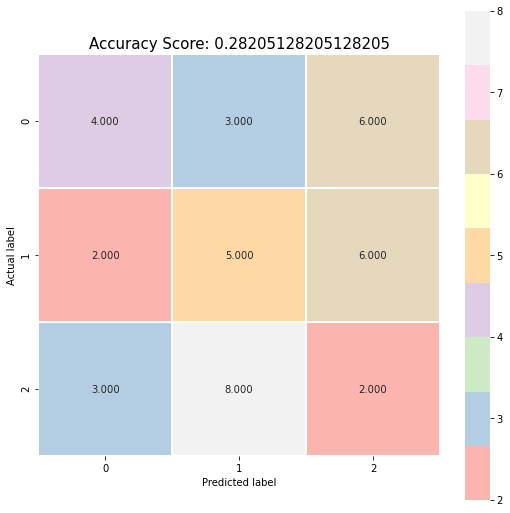

In [149]:
plot_confusion_matrix(cm,score )

In [150]:
cv_fivefold = cross_validate(estimator= lr, 
                             X = X_train_scaled,
                             y = y_train,
                             cv = 5,
                             n_jobs= -1, 
                             return_train_score= True, 
                             return_estimator= True, verbose = 2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [151]:
cv_fivefold['test_score']

array([0.41935484, 0.32258065, 0.35483871, 0.23333333, 0.33333333])

In [152]:
validation_mean = cv_fivefold['test_score'].mean()

validation_std = cv_fivefold['test_score'].std()

In [153]:
print('Vanilla Regression 5-fold cv results (Accuracy) %.3f =/- %.3f'%(validation_mean, validation_std))

Vanilla Regression 5-fold cv results (Accuracy) 0.333 =/- 0.060


In [154]:
#now lets try some different parameters
lr = LogisticRegression(penalty = 'l2', C = 1, solver = 'saga', max_iter= 1000)

In [155]:
lr.fit(X_train_scaled, y_train)

LogisticRegression(C=1, max_iter=1000, solver='saga')

In [156]:
y_pred = lr.predict(X_test_scaled)

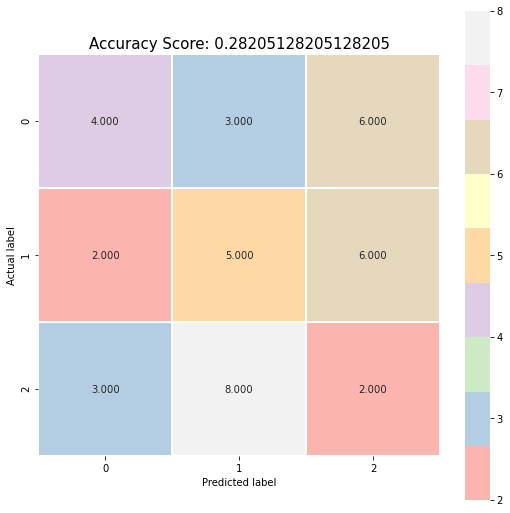

In [158]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), metrics.accuracy_score(y_test, y_pred))

In [159]:
cv_fivefold = cross_validate(estimator= lr, 
                             X = X_train_scaled,
                             y = y_train,
                             cv = 5,
                             return_train_score= True, 
                             return_estimator= True, verbose = 2)

[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [160]:
validation_mean = cv_fivefold['test_score'].mean()

validation_std = cv_fivefold['test_score'].std()

print('Vanilla Regression 5-fold cv results (Accuracy) %.3f =/- %.3f'%(validation_mean, validation_std))

Vanilla Regression 5-fold cv results (Accuracy) 0.339 =/- 0.082


In [161]:
#Grid Search CV
#now lets try to find the best parameters for logistic regression
grid = {'C': [0.0000000000001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2', 'none'], 'solver' : ['saga', 'lbfgs', 'sag', 'newton-cg'], "max_iter":[100,1000]}
grid_search_cv = GridSearchCV(estimator = lr, param_grid= grid, cv =5, return_train_score= True, verbose= 2)
grid_search_cv.fit(X_train_scaled, y_train)
grid_search_cv.cv_results_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] C=1e-13, max_iter=100, penalty=l1, solver=saga ..................
[CV] ... C=1e-13, max_iter=100, penalty=l1, solver=saga, total=   0.0s
[CV] C=1e-13, max_iter=100, penalty=l1, solver=saga ..................
[CV] ... C=1e-13, max_iter=100, penalty=l1, solver=saga, total=   0.0s
[CV] C=1e-13, max_iter=100, penalty=l1, solver=saga ..................
[CV] ... C=1e-13, max_iter=100, penalty=l1, solver=saga, total=   0.0s
[CV] C=1e-13, max_iter=100, penalty=l1, solver=saga ..................
[CV] ... C=1e-13, max_iter=100, penalty=l1, solver=saga, total=   0.0s
[CV] C=1e-13, max_iter=100, penalty=l1, solver=saga ..................
[CV] ... C=1e-13, max_iter=100, penalty=l1, solver=saga, total=   0.0s
[CV] C=1e-13, max_iter=100, penalty=l1, solver=lbfgs .................
[CV] .. C=1e-13, max_iter=100, penalty=l1, solver=lbfgs, total=   0.0s
[CV] C=1e-13, max_iter=100, penalty=l1, solver=lbfgs .................
[CV] .. C=1e-1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2

[CV]  C=1e-13, max_iter=100, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1e-13, max_iter=100, penalty=none, solver=saga ................
[CV] . C=1e-13, max_iter=100, penalty=none, solver=saga, total=   0.0s
[CV] C=1e-13, max_iter=100, penalty=none, solver=saga ................
[CV] . C=1e-13, max_iter=100, penalty=none, solver=saga, total=   0.0s
[CV] C=1e-13, max_iter=100, penalty=none, solver=saga ................
[CV] . C=1e-13, max_iter=100, penalty=none, solver=saga, total=   0.0s
[CV] C=1e-13, max_iter=100, penalty=none, solver=saga ................
[CV] . C=1e-13, max_iter=100, penalty=none, solver=saga, total=   0.0s
[CV] C=1e-13, max_iter=100, penalty=none, solver=saga ................
[CV] . C=1e-13, max_iter=100, penalty=none, solver=saga, total=   0.0s
[CV] C=1e-13, max_iter=100, penalty=none, solver=lbfgs ...............
[CV]  C=1e-13, max_iter=100, penalty=none, solver=lbfgs, total=   0.0s
[CV] C=1e-13, max_iter=100, penalty=none, solver=lbfgs ...............
[CV]

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1

[CV] .. C=1e-13, max_iter=1000, penalty=l1, solver=saga, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=l1, solver=lbfgs ................
[CV] . C=1e-13, max_iter=1000, penalty=l1, solver=lbfgs, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=l1, solver=lbfgs ................
[CV] . C=1e-13, max_iter=1000, penalty=l1, solver=lbfgs, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=l1, solver=lbfgs ................
[CV] . C=1e-13, max_iter=1000, penalty=l1, solver=lbfgs, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=l1, solver=lbfgs ................
[CV] . C=1e-13, max_iter=1000, penalty=l1, solver=lbfgs, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=l1, solver=lbfgs ................
[CV] . C=1e-13, max_iter=1000, penalty=l1, solver=lbfgs, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=l1, solver=sag ..................
[CV] ... C=1e-13, max_iter=1000, penalty=l1, solver=sag, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=l1, solver=sag ..................
[CV] .

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: Fi

[CV]  C=1e-13, max_iter=1000, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=l2, solver=newton-cg ............
[CV]  C=1e-13, max_iter=1000, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=l2, solver=newton-cg ............
[CV]  C=1e-13, max_iter=1000, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=l2, solver=newton-cg ............
[CV]  C=1e-13, max_iter=1000, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=none, solver=saga ...............
[CV]  C=1e-13, max_iter=1000, penalty=none, solver=saga, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=none, solver=saga ...............
[CV]  C=1e-13, max_iter=1000, penalty=none, solver=saga, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=none, solver=saga ...............
[CV]  C=1e-13, max_iter=1000, penalty=none, solver=saga, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=none, solver=saga ..........

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ZachV/opt/anaconda3/lib/p


[CV] C=1e-13, max_iter=1000, penalty=none, solver=newton-cg ..........
[CV]  C=1e-13, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=none, solver=newton-cg ..........
[CV]  C=1e-13, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=1e-13, max_iter=1000, penalty=none, solver=newton-cg ..........
[CV]  C=1e-13, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l1, solver=saga ...................
[CV] .... C=0.01, max_iter=100, penalty=l1, solver=saga, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l1, solver=saga ...................
[CV] .... C=0.01, max_iter=100, penalty=l1, solver=saga, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l1, solver=saga ...................
[CV] .... C=0.01, max_iter=100, penalty=l1, solver=saga, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=l1, solver=saga ...................
[CV] .... C=0.01, max_iter=100, penalty=l1, solver=saga, tota

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_mo

[CV]  C=0.01, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=none, solver=newton-cg ............
[CV]  C=0.01, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=none, solver=newton-cg ............
[CV]  C=0.01, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.01, max_iter=100, penalty=none, solver=newton-cg ............
[CV]  C=0.01, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.01, max_iter=1000, penalty=l1, solver=saga ..................
[CV] ... C=0.01, max_iter=1000, penalty=l1, solver=saga, total=   0.0s
[CV] C=0.01, max_iter=1000, penalty=l1, solver=saga ..................
[CV] ... C=0.01, max_iter=1000, penalty=l1, solver=saga, total=   0.0s
[CV] C=0.01, max_iter=1000, penalty=l1, solver=saga ..................
[CV] ... C=0.01, max_iter=1000, penalty=l1, solver=saga, total=   0.0s
[CV] C=0.01, max_iter=1000, penalty=l1, solver=saga .............

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logis

[CV]  C=0.01, max_iter=1000, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.01, max_iter=1000, penalty=l2, solver=newton-cg .............
[CV]  C=0.01, max_iter=1000, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.01, max_iter=1000, penalty=l2, solver=newton-cg .............
[CV]  C=0.01, max_iter=1000, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.01, max_iter=1000, penalty=l2, solver=newton-cg .............
[CV]  C=0.01, max_iter=1000, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.01, max_iter=1000, penalty=none, solver=saga ................
[CV] . C=0.01, max_iter=1000, penalty=none, solver=saga, total=   0.0s
[CV] C=0.01, max_iter=1000, penalty=none, solver=saga ................
[CV] . C=0.01, max_iter=1000, penalty=none, solver=saga, total=   0.0s
[CV] C=0.01, max_iter=1000, penalty=none, solver=saga ................
[CV] . C=0.01, max_iter=1000, penalty=none, solver=saga, total=   0.0s
[CV] C=0.01, max_iter=1000, penalty=none, solver=saga ...............

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_mo

[CV]  C=0.01, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.01, max_iter=1000, penalty=none, solver=newton-cg ...........
[CV]  C=0.01, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.01, max_iter=1000, penalty=none, solver=newton-cg ...........
[CV]  C=0.01, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.01, max_iter=1000, penalty=none, solver=newton-cg ...........
[CV]  C=0.01, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.01, max_iter=1000, penalty=none, solver=newton-cg ...........
[CV]  C=0.01, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l1, solver=saga ....................
[CV] ..... C=0.1, max_iter=100, penalty=l1, solver=saga, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l1, solver=saga ....................
[CV] ..... C=0.1, max_iter=100, penalty=l1, solver=saga, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l1, solver=saga .......

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s pe

[CV] .... C=0.1, max_iter=100, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=lbfgs ...................
[CV] .... C=0.1, max_iter=100, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=lbfgs ...................
[CV] .... C=0.1, max_iter=100, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=sag .....................
[CV] ...... C=0.1, max_iter=100, penalty=l2, solver=sag, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=sag .....................
[CV] ...... C=0.1, max_iter=100, penalty=l2, solver=sag, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=sag .....................
[CV] ...... C=0.1, max_iter=100, penalty=l2, solver=sag, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=sag .....................
[CV] ...... C=0.1, max_iter=100, penalty=l2, solver=sag, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=l2, solver=sag .....................
[CV] .

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_mo

[CV] .... C=0.1, max_iter=100, penalty=none, solver=sag, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=none, solver=sag ...................
[CV] .... C=0.1, max_iter=100, penalty=none, solver=sag, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=none, solver=sag ...................
[CV] .... C=0.1, max_iter=100, penalty=none, solver=sag, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=none, solver=newton-cg .............
[CV]  C=0.1, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=none, solver=newton-cg .............
[CV]  C=0.1, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=none, solver=newton-cg .............
[CV]  C=0.1, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=none, solver=newton-cg .............
[CV]  C=0.1, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.1, max_iter=100, penalty=none, solver=newton-cg ............

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s pe

[CV] .... C=0.1, max_iter=1000, penalty=l2, solver=saga, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=l2, solver=saga ...................
[CV] .... C=0.1, max_iter=1000, penalty=l2, solver=saga, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=l2, solver=saga ...................
[CV] .... C=0.1, max_iter=1000, penalty=l2, solver=saga, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=l2, solver=lbfgs ..................
[CV] ... C=0.1, max_iter=1000, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=l2, solver=lbfgs ..................
[CV] ... C=0.1, max_iter=1000, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=l2, solver=lbfgs ..................
[CV] ... C=0.1, max_iter=1000, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=l2, solver=lbfgs ..................
[CV] ... C=0.1, max_iter=1000, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=l2, solver=lbfgs ..................
[CV] .

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_mo


[CV] .. C=0.1, max_iter=1000, penalty=none, solver=saga, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=none, solver=saga .................
[CV] .. C=0.1, max_iter=1000, penalty=none, solver=saga, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=none, solver=saga .................
[CV] .. C=0.1, max_iter=1000, penalty=none, solver=saga, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=none, solver=lbfgs ................
[CV] . C=0.1, max_iter=1000, penalty=none, solver=lbfgs, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=none, solver=lbfgs ................
[CV] . C=0.1, max_iter=1000, penalty=none, solver=lbfgs, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=none, solver=lbfgs ................
[CV] . C=0.1, max_iter=1000, penalty=none, solver=lbfgs, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=none, solver=lbfgs ................
[CV] . C=0.1, max_iter=1000, penalty=none, solver=lbfgs, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=none, solver=lbfgs ................
[CV] 

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_mo


[CV] C=0.1, max_iter=1000, penalty=none, solver=sag ..................
[CV] ... C=0.1, max_iter=1000, penalty=none, solver=sag, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=none, solver=sag ..................
[CV] ... C=0.1, max_iter=1000, penalty=none, solver=sag, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=none, solver=sag ..................
[CV] ... C=0.1, max_iter=1000, penalty=none, solver=sag, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=none, solver=newton-cg ............
[CV]  C=0.1, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=none, solver=newton-cg ............
[CV]  C=0.1, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=none, solver=newton-cg ............
[CV]  C=0.1, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=0.1, max_iter=1000, penalty=none, solver=newton-cg ............
[CV]  C=0.1, max_iter=1000, penalty=none, solver=newton-cg, total= 

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logis

[CV] ........ C=1, max_iter=100, penalty=l2, solver=sag, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=newton-cg .................
[CV] .. C=1, max_iter=100, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=newton-cg .................
[CV] .. C=1, max_iter=100, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=newton-cg .................
[CV] .. C=1, max_iter=100, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=newton-cg .................
[CV] .. C=1, max_iter=100, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1, max_iter=100, penalty=l2, solver=newton-cg .................
[CV] .. C=1, max_iter=100, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=1, max_iter=100, penalty=none, solver=saga ....................
[CV] ..... C=1, max_iter=100, penalty=none, solver=saga, total=   0.0s
[CV] C=1, max_iter=100, penalty=none, solver=saga ....................
[CV] .

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty."

[CV]  C=1, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=1, max_iter=100, penalty=none, solver=newton-cg ...............
[CV]  C=1, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=1, max_iter=100, penalty=none, solver=newton-cg ...............
[CV]  C=1, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=1, max_iter=100, penalty=none, solver=newton-cg ...............
[CV]  C=1, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=1, max_iter=1000, penalty=l1, solver=saga .....................
[CV] ...... C=1, max_iter=1000, penalty=l1, solver=saga, total=   0.0s
[CV] C=1, max_iter=1000, penalty=l1, solver=saga .....................
[CV] ...... C=1, max_iter=1000, penalty=l1, solver=saga, total=   0.0s
[CV] C=1, max_iter=1000, penalty=l1, solver=saga .....................
[CV] ...... C=1, max_iter=1000, penalty=l1, solver=saga, total=   0.0s
[CV] C=1, max_iter=1000, penalty=l1, solver=saga .....................
[CV] .

[CV]  C=1, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=1, max_iter=1000, penalty=none, solver=newton-cg ..............
[CV]  C=1, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=1, max_iter=1000, penalty=none, solver=newton-cg ..............
[CV]  C=1, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=1, max_iter=1000, penalty=none, solver=newton-cg ..............
[CV]  C=1, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=100, penalty=l1, solver=saga .....................
[CV] ...... C=10, max_iter=100, penalty=l1, solver=saga, total=   0.0s
[CV] C=10, max_iter=100, penalty=l1, solver=saga .....................
[CV] ...... C=10, max_iter=100, penalty=l1, solver=saga, total=   0.0s
[CV] C=10, max_iter=100, penalty=l1, solver=saga .....................
[CV] ...... C=10, max_iter=100, penalty=l1, solver=saga, total=   0.0s
[CV] C=10, max_iter=100, penalty=l1, solver=saga .....................
[C

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 

[CV] . C=10, max_iter=100, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=newton-cg ................
[CV] . C=10, max_iter=100, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=newton-cg ................
[CV] . C=10, max_iter=100, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=newton-cg ................
[CV] . C=10, max_iter=100, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=100, penalty=l2, solver=newton-cg ................
[CV] . C=10, max_iter=100, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=100, penalty=none, solver=saga ...................
[CV] .... C=10, max_iter=100, penalty=none, solver=saga, total=   0.0s
[CV] C=10, max_iter=100, penalty=none, solver=saga ...................
[CV] .... C=10, max_iter=100, penalty=none, solver=saga, total=   0.0s
[CV] C=10, max_iter=100, penalty=none, solver=saga ...................
[CV] .

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_mo

[CV]  C=10, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=100, penalty=none, solver=newton-cg ..............
[CV]  C=10, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=100, penalty=none, solver=newton-cg ..............
[CV]  C=10, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=100, penalty=none, solver=newton-cg ..............
[CV]  C=10, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=100, penalty=none, solver=newton-cg ..............
[CV]  C=10, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=1000, penalty=l1, solver=saga ....................
[CV] ..... C=10, max_iter=1000, penalty=l1, solver=saga, total=   0.0s
[CV] C=10, max_iter=1000, penalty=l1, solver=saga ....................
[CV] ..... C=10, max_iter=1000, penalty=l1, solver=saga, total=   0.0s
[CV] C=10, max_iter=1000, penalty=l1, solver=saga ....................
[

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: Fi

[CV] .... C=10, max_iter=1000, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=10, max_iter=1000, penalty=l2, solver=sag .....................
[CV] ...... C=10, max_iter=1000, penalty=l2, solver=sag, total=   0.0s
[CV] C=10, max_iter=1000, penalty=l2, solver=sag .....................
[CV] ...... C=10, max_iter=1000, penalty=l2, solver=sag, total=   0.0s
[CV] C=10, max_iter=1000, penalty=l2, solver=sag .....................
[CV] ...... C=10, max_iter=1000, penalty=l2, solver=sag, total=   0.0s
[CV] C=10, max_iter=1000, penalty=l2, solver=sag .....................
[CV] ...... C=10, max_iter=1000, penalty=l2, solver=sag, total=   0.0s
[CV] C=10, max_iter=1000, penalty=l2, solver=sag .....................
[CV] ...... C=10, max_iter=1000, penalty=l2, solver=sag, total=   0.0s
[CV] C=10, max_iter=1000, penalty=l2, solver=newton-cg ...............
[CV]  C=10, max_iter=1000, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=1000, penalty=l2, solver=newton-cg ...............
[CV]  

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_mo

[CV] .... C=10, max_iter=1000, penalty=none, solver=sag, total=   0.0s
[CV] C=10, max_iter=1000, penalty=none, solver=sag ...................
[CV] .... C=10, max_iter=1000, penalty=none, solver=sag, total=   0.0s
[CV] C=10, max_iter=1000, penalty=none, solver=sag ...................
[CV] .... C=10, max_iter=1000, penalty=none, solver=sag, total=   0.0s
[CV] C=10, max_iter=1000, penalty=none, solver=newton-cg .............
[CV]  C=10, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=1000, penalty=none, solver=newton-cg .............
[CV]  C=10, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=1000, penalty=none, solver=newton-cg .............
[CV]  C=10, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=1000, penalty=none, solver=newton-cg .............
[CV]  C=10, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=10, max_iter=1000, penalty=none, solver=newton-cg ............

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-package


[CV] C=100, max_iter=100, penalty=l2, solver=lbfgs ...................
[CV] .... C=100, max_iter=100, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=lbfgs ...................
[CV] .... C=100, max_iter=100, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=lbfgs ...................
[CV] .... C=100, max_iter=100, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=sag .....................
[CV] ...... C=100, max_iter=100, penalty=l2, solver=sag, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=sag .....................
[CV] ...... C=100, max_iter=100, penalty=l2, solver=sag, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=sag .....................
[CV] ...... C=100, max_iter=100, penalty=l2, solver=sag, total=   0.0s
[CV] C=100, max_iter=100, penalty=l2, solver=sag .....................
[CV] ...... C=100, max_iter=100, penalty=l2, solver=sag, total=   0.0s
[CV] 

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_mo


[CV] C=100, max_iter=100, penalty=none, solver=sag ...................
[CV] .... C=100, max_iter=100, penalty=none, solver=sag, total=   0.0s
[CV] C=100, max_iter=100, penalty=none, solver=sag ...................
[CV] .... C=100, max_iter=100, penalty=none, solver=sag, total=   0.0s
[CV] C=100, max_iter=100, penalty=none, solver=sag ...................
[CV] .... C=100, max_iter=100, penalty=none, solver=sag, total=   0.0s
[CV] C=100, max_iter=100, penalty=none, solver=sag ...................
[CV] .... C=100, max_iter=100, penalty=none, solver=sag, total=   0.0s
[CV] C=100, max_iter=100, penalty=none, solver=sag ...................
[CV] .... C=100, max_iter=100, penalty=none, solver=sag, total=   0.0s
[CV] C=100, max_iter=100, penalty=none, solver=newton-cg .............
[CV]  C=100, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=100, max_iter=100, penalty=none, solver=newton-cg .............
[CV]  C=100, max_iter=100, penalty=none, solver=newton-cg, total=   0.0s
[

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 

[CV] .... C=100, max_iter=1000, penalty=l1, solver=saga, total=   0.1s
[CV] C=100, max_iter=1000, penalty=l1, solver=saga ...................
[CV] .... C=100, max_iter=1000, penalty=l1, solver=saga, total=   0.0s
[CV] C=100, max_iter=1000, penalty=l1, solver=saga ...................
[CV] .... C=100, max_iter=1000, penalty=l1, solver=saga, total=   0.0s
[CV] C=100, max_iter=1000, penalty=l1, solver=lbfgs ..................
[CV] ... C=100, max_iter=1000, penalty=l1, solver=lbfgs, total=   0.0s
[CV] C=100, max_iter=1000, penalty=l1, solver=lbfgs ..................
[CV] ... C=100, max_iter=1000, penalty=l1, solver=lbfgs, total=   0.0s
[CV] C=100, max_iter=1000, penalty=l1, solver=lbfgs ..................
[CV] ... C=100, max_iter=1000, penalty=l1, solver=lbfgs, total=   0.0s
[CV] C=100, max_iter=1000, penalty=l1, solver=lbfgs ..................
[CV] ... C=100, max_iter=1000, penalty=l1, solver=lbfgs, total=   0.0s
[CV] C=100, max_iter=1000, penalty=l1, solver=lbfgs ..................
[CV] .

/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_mo

[CV]  C=100, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=100, max_iter=1000, penalty=none, solver=newton-cg ............
[CV]  C=100, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s
[CV] C=100, max_iter=1000, penalty=none, solver=newton-cg ............
[CV]  C=100, max_iter=1000, penalty=none, solver=newton-cg, total=   0.0s


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    5.9s finished


{'mean_fit_time': array([0.00266743, 0.00051761, 0.0005312 , 0.00060649, 0.00237398,
        0.0041625 , 0.00244403, 0.01705117, 0.00357442, 0.00794969,
        0.00485363, 0.0136795 , 0.00227008, 0.00055881, 0.00055299,
        0.00049043, 0.00389752, 0.00661025, 0.00386562, 0.03018641,
        0.0027967 , 0.00798836, 0.00387678, 0.01839933, 0.00347276,
        0.00085206, 0.0006362 , 0.00060534, 0.002531  , 0.00587645,
        0.00264454, 0.01465178, 0.0036582 , 0.01128445, 0.00661197,
        0.01739035, 0.00200276, 0.00045238, 0.0004858 , 0.00048213,
        0.00240278, 0.00627217, 0.00300083, 0.01627789, 0.00407228,
        0.01002026, 0.00479093, 0.02076864, 0.00426517, 0.0005054 ,
        0.00054483, 0.00061927, 0.00365596, 0.0066299 , 0.0034574 ,
        0.01137652, 0.00310302, 0.00856771, 0.00501766, 0.01988039,
        0.00382719, 0.00048003, 0.00052233, 0.00053492, 0.00290365,
        0.00825758, 0.00275378, 0.01406655, 0.00745859, 0.02399979,
        0.01240292, 0.0317853 ,

In [162]:
pd.DataFrame(grid_search_cv.cv_results_ ).sort_values('mean_test_score', ascending = False).T

,60,48,30,28,31,40,41,42,43,29,...,99,109,110,111,121,122,123,133,134,135
mean_fit_time,0.00382719,0.00426517,0.00264454,0.002531,0.0146518,0.00240278,0.00627217,0.00300083,0.0162779,0.00587645,...,0.000449562,0.0008708,0.00041399,0.000524378,0.000401545,0.000632381,0.000367403,0.00039115,0.000460625,0.000430775
std_fit_time,0.00152581,0.00164002,0.000184813,0.000247951,0.00633752,0.000305889,0.000773046,0.000624475,0.00654349,0.000227512,...,6.42257e-05,0.000747144,4.6709e-05,8.82713e-05,0.000101549,0.000276426,5.43224e-05,9.31814e-05,3.00438e-05,2.5812e-05
mean_score_time,0.000853634,0.000557089,0.000497723,0.000447989,0.000494576,0.000449705,0.000560141,0.000564718,0.000781536,0.00051651,...,0,0,0,0,0,0,0,0,0,0
std_score_time,0.000706085,8.72893e-05,8.88058e-05,1.19562e-05,2.64477e-05,2.63827e-05,0.000118186,0.00019918,0.000339343,4.97982e-05,...,0,0,0,0,0,0,0,0,0,0
param_C,0.1,0.1,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,10,10,10,10,100,100,100,100,100,100
param_max_iter,1000,100,100,100,100,1000,1000,1000,1000,100,...,100,1000,1000,1000,100,100,100,1000,1000,1000
param_penalty,l1,l1,l2,l2,l2,l2,l2,l2,l2,l2,...,l1,l1,l1,l1,l1,l1,l1,l1,l1,l1
param_solver,saga,saga,sag,saga,newton-cg,saga,lbfgs,sag,newton-cg,lbfgs,...,newton-cg,lbfgs,sag,newton-cg,lbfgs,sag,newton-cg,lbfgs,sag,newton-cg
params,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', ...","{'C': 0.1, 'max_iter': 100, 'penalty': 'l1', '...","{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...","{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...","{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2',...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2',...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2',...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2',...","{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...",...,"{'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...","{'C': 10, 'max_iter': 1000, 'penalty': 'l1', '...","{'C': 10, 'max_iter': 1000, 'penalty': 'l1', '...","{'C': 10, 'max_iter': 1000, 'penalty': 'l1', '...","{'C': 100, 'max_iter': 100, 'penalty': 'l1', '...","{'C': 100, 'max_iter': 100, 'penalty': 'l1', '...","{'C': 100, 'max_iter': 100, 'penalty': 'l1', '...","{'C': 100, 'max_iter': 1000, 'penalty': 'l1', ...","{'C': 100, 'max_iter': 1000, 'penalty': 'l1', ...","{'C': 100, 'max_iter': 1000, 'penalty': 'l1', ..."
split0_test_score,0.419355,0.419355,0.354839,0.354839,0.354839,0.354839,0.354839,0.354839,0.354839,0.354839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
#Optimal LR model:
lr = LogisticRegression(C = 0.1, penalty = 'l1', solver = 'saga', max_iter= 1000)

In [164]:
cv_fivefold = cross_validate(estimator= lr, 
                             X = X_train_scaled,
                             y = y_train,
                             cv = 5,
                             return_train_score= True, 
                             return_estimator= True, verbose = 2)

[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [166]:
validation_mean = cv_fivefold['test_score'].mean()

validation_std = cv_fivefold['test_score'].std()

print('Logistic Regression 5-fold cv results (Accuracy) %.3f =/- %.3f'%(validation_mean, validation_std))

Logistic Regression 5-fold cv results (Accuracy) 0.405 =/- 0.029


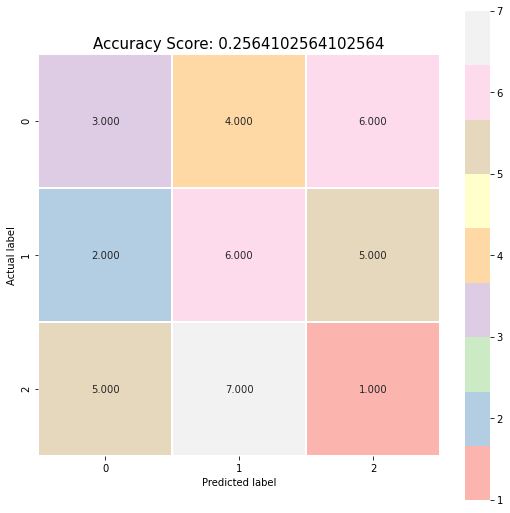

In [169]:
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), lr.score(X_test_scaled, y_test))

In [170]:
#Lastly, lets do some experimentation with random forests

rf = RandomForestClassifier(n_estimators= 700, max_features='auto', max_depth= 10)

In [189]:
#Grid Search CV
#now lets try to find the best parameters for random forests
#this takes a pretty long time to run, so gave faster option below
#grid = {'n_estimators': [50,300,500,700], 'max_leaf_nodes': [5, 15, 25, 100], 'ccp_alpha': [0, 0.01, 0.1, 1, 10], 'criterion' : ['gini', 'entropy'], "min_impurity_split":[0,0.1,0.3,0.5], "n_jobs": [4]}
grid = {'n_estimators': [50,700], 'max_leaf_nodes': [15, 100], 'ccp_alpha': [0, 0.1], 'criterion' : ['gini'], "min_impurity_split":[0,0.1,0.5], "n_jobs": [4]}
grid_search_cv = GridSearchCV(estimator = rf, param_grid= grid, cv =5, return_train_score= True, verbose= 2)
grid_search_cv.fit(X_train_scaled, y_train)
grid_search_cv.cv_results_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4, total=   2.3s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4, total=   0.2s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4, total=   0.2s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4, total=   0.2s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, n_estimators=50, n_jobs=4, total=   0.2s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, n_estimators=700, n_jobs=4 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=15, min_impurity_split=0, n_estimators=700, n_jobs=4, total=   1.5s
[CV] 

[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0, n_estimators=700, n_jobs=4, total=   2.2s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0, n_estimators=700, n_jobs=4 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0, n_estimators=700, n_jobs=4, total=   7.0s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.1, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.1, n_estimators=50, n_jobs=4, total=   0.3s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.1, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.1, n_estimators=50, n_jobs=4, total=   0.3s
[CV] ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.1, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.1, n_estimators=50, n_jobs=

[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.1, n_estimators=700, n_jobs=4, total=   1.4s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.1, n_estimators=700, n_jobs=4 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.1, n_estimators=700, n_jobs=4, total=   1.3s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.1, n_estimators=700, n_jobs=4 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.1, n_estimators=700, n_jobs=4, total=   1.2s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.1, n_estimators=700, n_jobs=4 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.1, n_estimators=700, n_jobs=4, total=   1.3s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.1, n_estimators=700, n_jobs=4 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=15, min_impurity_split=0.1, n_es

[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.5, n_estimators=50, n_jobs=4, total=   0.2s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.5, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.5, n_estimators=50, n_jobs=4, total=   0.2s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.5, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.5, n_estimators=50, n_jobs=4, total=   0.2s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.5, n_estimators=50, n_jobs=4 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.5, n_estimators=50, n_jobs=4, total=   0.2s
[CV] ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.5, n_estimators=700, n_jobs=4 
[CV]  ccp_alpha=0.1, criterion=gini, max_leaf_nodes=100, min_impurity_split=0.5, n_

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.1min finished
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users

{'mean_fit_time': array([0.53741302, 1.18879128, 0.10970564, 1.27485046, 0.16725249,
        1.6366858 , 0.22530541, 2.50786042, 0.18754334, 1.43720999,
        0.10623779, 1.22418122, 0.19761891, 1.65075998, 0.1210391 ,
        1.17025633, 0.11134305, 1.4926609 , 0.11447139, 1.19468861,
        0.11362991, 1.27290192, 0.12039046, 1.34418302]),
 'std_fit_time': array([0.8412664 , 0.07845077, 0.00477167, 0.1454924 , 0.04982739,
        0.41326885, 0.13856491, 2.13295011, 0.00322902, 0.22153576,
        0.00310543, 0.10081051, 0.11828627, 0.25737095, 0.00747816,
        0.04488515, 0.00599598, 0.2917196 , 0.00757669, 0.01509702,
        0.00574613, 0.07444367, 0.00345722, 0.23065328]),
 'mean_score_time': array([0.10360241, 0.12633319, 0.10345955, 0.10727816, 0.10555849,
        0.2094604 , 0.10885706, 0.23574615, 0.10518084, 0.10477104,
        0.10397153, 0.14553185, 0.10545254, 0.18772535, 0.10511327,
        0.1064683 , 0.10489798, 0.1255281 , 0.10462804, 0.10619888,
        0.105920

In [190]:
pd.DataFrame(grid_search_cv.cv_results_ ).sort_values('mean_test_score', ascending = False).T

,4,6,5,3,11,0,2,10,1,9,...,20,18,12,14,17,21,15,19,13,23
mean_fit_time,0.167252,0.225305,1.63669,1.27485,1.22418,0.537413,0.109706,0.106238,1.18879,1.43721,...,0.11363,0.114471,0.197619,0.121039,1.49266,1.2729,1.17026,1.19469,1.65076,1.34418
std_fit_time,0.0498274,0.138565,0.413269,0.145492,0.100811,0.841266,0.00477167,0.00310543,0.0784508,0.221536,...,0.00574613,0.00757669,0.118286,0.00747816,0.29172,0.0744437,0.0448852,0.015097,0.257371,0.230653
mean_score_time,0.105558,0.108857,0.20946,0.107278,0.145532,0.103602,0.10346,0.103972,0.126333,0.104771,...,0.10592,0.104628,0.105453,0.105113,0.125528,0.165873,0.106468,0.106199,0.187725,0.127864
std_score_time,0.00266053,0.00553779,0.00580405,0.00022093,0.0493213,0.00122556,0.000938059,0.00104273,0.0406729,0.00151367,...,0.000546202,0.000965014,0.0016432,0.00156314,0.0423879,0.0492323,0.00103956,0.000974391,0.0429207,0.0435473
param_ccp_alpha,0,0,0,0,0,0,0,0,0,0,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
param_criterion,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,...,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini
param_max_leaf_nodes,15,100,15,15,100,15,15,100,15,100,...,100,100,15,15,15,100,15,100,15,100
param_min_impurity_split,0.5,0,0.5,0.1,0.5,0,0.1,0.5,0,0.1,...,0.1,0,0,0.1,0.5,0.1,0.1,0,0,0.5
param_n_estimators,50,50,700,700,700,50,50,50,700,700,...,50,50,50,50,700,700,700,700,700,700
param_n_jobs,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [195]:
#create the optimal random forest classifier

rf = RandomForestClassifier(max_leaf_nodes = 15, min_impurity_split = 0.5, n_estimators= 50, max_features='auto')

cv_fivefold = cross_validate(estimator= rf, 
                             X = X_train,
                             y = y_train,
                             cv = 5,
                             return_train_score= True, 
                             return_estimator= True, 
                             verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarn

[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s


/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:310: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)
/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes

In [196]:
validation_mean = cv_fivefold['test_score'].mean()

validation_std = cv_fivefold['test_score'].std()

print('Random Forest 5-fold cv results (Accuracy) %.3f =/- %.3f'%(validation_mean, validation_std))

Random Forest 5-fold cv results (Accuracy) 0.392 =/- 0.086
